* By: Aditya Vyas
* Email: adityavyas17@gmail.com
* Reference: Advances in Financial Machine Learning, Chapter-16

## Chapter 16 Machine Learning Asset Allocation

## Introduction

Portfolio optimisation and asset allocation have been important topics in the financial world. Although, the classical Markowitz theory has been successful, it has a lot of limitations in its practical implementations. Optimisation algorithms like CLA involve taking the inverse of covariance matrices which leads to instability for large portfolios - escpecially if they are highly correlated. This is where the Hierarchical Risk Parity algorithm comes in - it does not deal with inverse of a covariance matrix hence removing the instability of the previous algorithms. 

This notebook explores the exercises at the back of Chapter-16 in the book "Advances in Financial Machine Learning". We will use the portfolio optimisation algorithms in the mlfinlab package to do a comparision of their performance. The questions are restated here in this notebook, with the accompanying code solutions following directly below each question.

In [2]:
import numbers
import numpy as np
import scipy as sc
import pandas as pd
import random
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Import from mlfinlab
from mlfinlab.portfolio_optimization.cla import CLA
from mlfinlab.portfolio_optimization.hrp import HierarchicalRiskParity
from mlfinlab.portfolio_optimization.mean_variance import MeanVarianceOptimisation

# Modified functions for some of the questions
from hrp_modified import HierarchicalRiskParityModified
from cla_modified import CLAModified
from mvo_modified import MeanVarianceOptimisationModified

%matplotlib inline
np.random.seed(42)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Getting the Data

In [3]:
stock_prices = pd.read_csv('../Sample-Data/stock_prices.csv', parse_dates=True, index_col='Date')
stock_prices = stock_prices.dropna(axis=1)


In [4]:
stock_prices.head()

,EEM,EWG,TIP,EWJ,EFA,IEF,EWQ,EWU,XLB,XLE,...,XLU,EPP,FXI,VGK,VPL,SPY,TLT,BND,CSJ,DIA
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-02,49.27333,35.39000,106.64000,52.92000,78.22000,87.63000,37.94000,47.76000,41.30000,79.50000,...,42.09000,51.17333,55.98333,74.53000,67.31000,144.92999,94.38000,77.36000,101.40000,130.63000
2008-01-03,49.71667,35.29000,107.00000,53.12000,78.35000,87.81000,37.92000,48.06000,42.05000,80.44000,...,42.03000,51.29333,55.60000,74.80000,67.50000,144.86000,94.25000,77.46000,101.52000,130.74001
2008-01-04,48.22333,34.60000,106.97000,51.76000,76.57000,88.04000,36.99000,46.92000,40.78000,77.50000,...,42.35000,49.85000,54.53667,72.98000,65.77000,141.31000,94.27000,77.55000,101.65000,128.17000
2008-01-07,48.57667,34.63000,106.95000,51.44000,76.65000,88.20000,37.26000,47.06000,40.22000,77.20000,...,43.23000,50.41667,56.11667,72.95000,65.65000,141.19000,94.68000,77.57000,101.72000,128.06000
2008-01-08,48.20000,34.39000,107.03000,51.32000,76.22000,88.39000,36.97000,46.40000,39.60000,75.85000,...,43.24000,49.56667,55.32667,72.40000,65.36000,138.91000,94.57000,77.65000,101.74000,125.85000


## Question-16.1

### Given the PnL series on N investment strategies:
### (a) Align them to the average frequency of their bets (e.g., weekly observations for strategies that trade on a weekly basis). Hint: This kind of data alignment is sometimes called “downsampling.”

Using, the **resample()** function in pandas, we can do the required downsampling. 'W' parameter refers to Weekly resampling

In [5]:
stock_prices_downsampled = stock_prices.resample('W').last()

In [6]:
stock_prices_downsampled.head()

,EEM,EWG,TIP,EWJ,EFA,IEF,EWQ,EWU,XLB,XLE,...,XLU,EPP,FXI,VGK,VPL,SPY,TLT,BND,CSJ,DIA
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-06,48.22333,34.60000,106.97000,51.76000,76.57000,88.04000,36.99000,46.92000,40.78000,77.50000,...,42.35000,49.85000,54.53667,72.98000,65.77000,141.31000,94.27000,77.55000,101.65000,128.17000
2008-01-13,48.95000,34.11000,107.26000,51.12000,75.16000,88.57000,36.46000,45.20000,39.98000,75.60000,...,43.43000,49.52333,56.66667,71.24000,65.11000,140.14999,94.20000,77.77000,102.19000,126.19000
2008-01-20,45.13334,32.23000,108.50000,50.00000,71.71000,89.61000,34.58000,43.24000,37.35000,68.90000,...,40.03000,46.31000,52.31333,67.49000,62.59000,132.06000,95.49000,78.28000,102.65000,120.57000
2008-01-27,44.45333,30.01000,109.20000,49.88000,70.69000,90.20000,33.09000,43.42000,38.44000,68.70000,...,38.18000,47.21333,49.61000,65.90000,63.02000,133.03999,95.95000,78.65000,103.37000,122.19000
2008-02-03,46.54000,31.45000,109.08000,51.32000,73.55000,89.94000,34.61000,44.92000,40.92000,71.35000,...,40.24000,48.98333,50.23333,69.04000,65.13000,139.58000,95.23000,78.31000,102.97000,127.43000


To calculate the returns, the prices dataframe has to be indexed by date.

In [7]:
stock_returns = stock_prices_downsampled.pct_change().dropna(how='all')
stock_returns.head()


,EEM,EWG,TIP,EWJ,EFA,IEF,EWQ,EWU,XLB,XLE,...,XLU,EPP,FXI,VGK,VPL,SPY,TLT,BND,CSJ,DIA
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-13,0.01507,-0.01416,0.00271,-0.01236,-0.01841,0.00602,-0.01433,-0.03666,-0.01962,-0.02452,...,0.02550,-0.00655,0.03906,-0.02384,-0.01003,-0.00821,-0.00074,0.00284,0.00531,-0.01545
2008-01-20,-0.07797,-0.05512,0.01156,-0.02191,-0.04590,0.01174,-0.05156,-0.04336,-0.06578,-0.08862,...,-0.07829,-0.06489,-0.07682,-0.05264,-0.03870,-0.05772,0.01369,0.00656,0.00450,-0.04454
2008-01-27,-0.01507,-0.06888,0.00645,-0.00240,-0.01422,0.00658,-0.04309,0.00416,0.02918,-0.00290,...,-0.04622,0.01951,-0.05168,-0.02356,0.00687,0.00742,0.00482,0.00473,0.00701,0.01344
2008-02-03,0.04694,0.04798,-0.00110,0.02887,0.04046,-0.00288,0.04594,0.03455,0.06452,0.03857,...,0.05395,0.03749,0.01256,0.04765,0.03348,0.04916,-0.00750,-0.00432,-0.00387,0.04288
2008-02-10,-0.05243,-0.05342,-0.00422,-0.06781,-0.07084,-0.00322,-0.08003,-0.05744,-0.02664,-0.02102,...,-0.03082,-0.06791,-0.06005,-0.06793,-0.06940,-0.04664,-0.01607,-0.00613,0.00214,-0.04457


The pct_change() function calculates the percentage change with the previous day price for each asset. This gives us the returns for that asset for different time periods.

### (b) Compute the covariance of their returns, V

In [8]:
V = stock_returns.cov()

<Figure size 504x504 with 0 Axes>

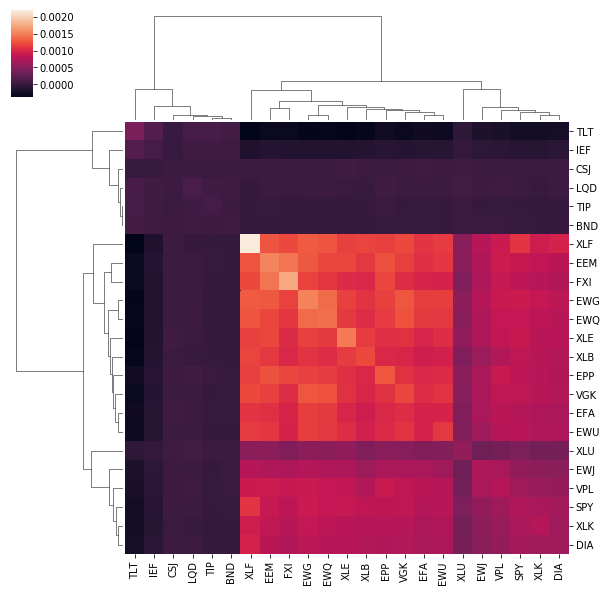

In [9]:
plt.figure(figsize=(7, 7))
sns.clustermap(V)
plt.show()

### (c) Identify the hierarchical clusters among the N strategies

In [10]:
correlation = stock_returns.corr()
distances = np.sqrt((1 - correlation) / 2)
clusters = linkage(squareform(distances), method="single")
clusters


array([[18.        , 22.        ,  0.10747657,  2.        ],
       [ 4.        , 16.        ,  0.10917731,  2.        ],
       [ 6.        , 24.        ,  0.12945876,  3.        ],
       [ 1.        , 25.        ,  0.16024057,  4.        ],
       [ 7.        , 26.        ,  0.16912907,  5.        ],
       [ 3.        , 17.        ,  0.177188  ,  2.        ],
       [27.        , 28.        ,  0.19544265,  7.        ],
       [12.        , 23.        ,  0.20099293,  3.        ],
       [14.        , 29.        ,  0.21063886,  8.        ],
       [30.        , 31.        ,  0.21901211, 11.        ],
       [ 0.        , 32.        ,  0.23045824, 12.        ],
       [ 5.        , 19.        ,  0.23713254,  2.        ],
       [ 8.        , 33.        ,  0.24357927, 13.        ],
       [15.        , 35.        ,  0.24585138, 14.        ],
       [10.        , 36.        ,  0.26179476, 15.        ],
       [ 9.        , 37.        ,  0.26943771, 16.        ],
       [11.        , 20.

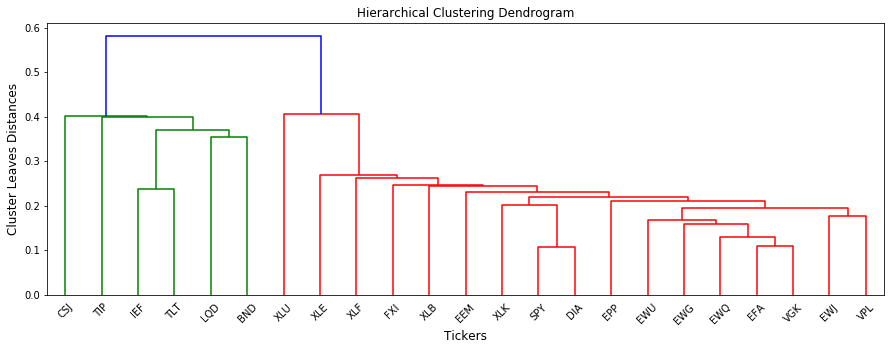

In [11]:
columns = stock_returns.columns
plt.figure(figsize=(15, 5))
dendrogram(clusters, labels=columns)
plt.xlabel('Tickers', fontsize=12)
plt.ylabel('Cluster Leaves Distances', fontsize=12)
plt.title('Hierarchical Clustering Dendrogram', fontsize=12)
plt.show()


### (d) Plot the clustered correlation matrix of the N strategies

<Figure size 504x504 with 0 Axes>

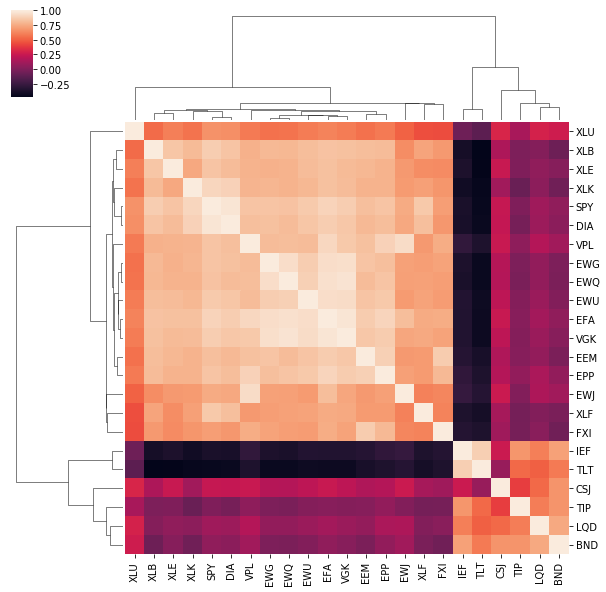

In [12]:
plt.figure(figsize=(7, 7))
sns.clustermap(stock_returns.corr())
plt.show()

## Question-16.2

### Using the clustered covariance matrix V from exercise 1:

Each class in mlfinlab's portfolio_optimisation module has an **allocate()** method which takes the raw stock prices, calculates the returns and finds the optimal weights. There is also an option to resample the prices and so we will simply pass the raw stock prices without any downsampling. For our case, we will specify 'W' for weekly resampling.

### (a) Compute the HRP allocations

In [13]:
hrp = HierarchicalRiskParity()
hrp.allocate(asset_prices=stock_prices, resample_by='W')
hrp_weights = hrp.weights.sort_values(by=0, ascending=False, axis=1)


In [14]:
hrp_weights

,BND,CSJ,TIP,IEF,LQD,XLU,TLT,DIA,XLE,XLB,...,EWJ,XLK,VPL,FXI,EEM,EWG,EFA,EWU,EPP,EWQ
0,0.36356,0.27426,0.11938,0.08572,0.04817,0.02016,0.01346,0.00848,0.00792,0.00635,...,0.00456,0.00455,0.00442,0.00440,0.00436,0.00394,0.00316,0.00261,0.00228,0.00218


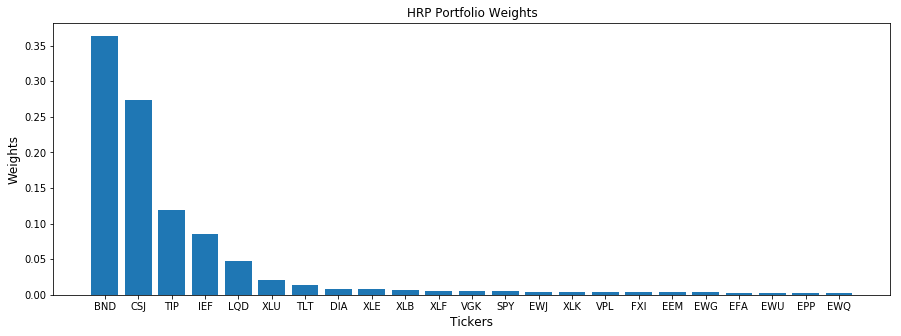

In [15]:
plt.figure(figsize=(15, 5))
plt.bar(hrp_weights.columns, hrp_weights.values[0])
plt.xlabel('Tickers', fontsize=12)
plt.ylabel('Weights', fontsize=12)
plt.title('HRP Portfolio Weights', fontsize=12)
plt.show()


### (b) Compute the CLA allocations

We will calculate the minimum variance (min_volatility) solution using CLA.

In [16]:
cla = CLA()
cla.allocate(asset_prices=stock_prices, resample_by='W', solution='min_volatility')
cla_weights = cla.weights.sort_values(by=0, ascending=False, axis=1)


In [17]:
cla_weights

,CSJ,EWQ,BND,EEM,XLK,TLT,SPY,VPL,VGK,FXI,...,EWG,XLF,XLE,XLB,EWU,IEF,EFA,EWJ,TIP,DIA
0,0.72049,0.15989,0.11962,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


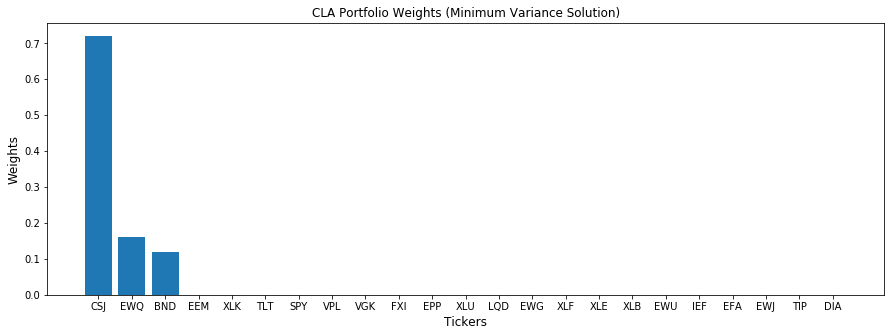

In [18]:
plt.figure(figsize=(15, 5))
plt.bar(cla_weights.columns, cla_weights.values[0])
plt.xlabel('Tickers', fontsize=12)
plt.ylabel('Weights', fontsize=12)
plt.title('CLA Portfolio Weights (Minimum Variance Solution)', fontsize=12)
plt.show()


### Compute the IVP allocations

In [19]:
mvo = MeanVarianceOptimisation()
mvo.allocate(asset_prices=stock_prices, solution='inverse_variance', resample_by='W')
ivp_weights = mvo.weights.sort_values(by=0, ascending=False, axis=1)


In [20]:
ivp_weights

,CSJ,BND,TIP,IEF,LQD,TLT,XLU,DIA,SPY,EWJ,...,EWU,VGK,XLB,EPP,EWQ,XLE,EWG,EEM,FXI,XLF
0,0.26693,0.21401,0.11619,0.11174,0.08931,0.02496,0.01838,0.01655,0.01428,0.01420,...,0.00947,0.00885,0.00875,0.00828,0.00751,0.00722,0.00698,0.00694,0.00607,0.00485


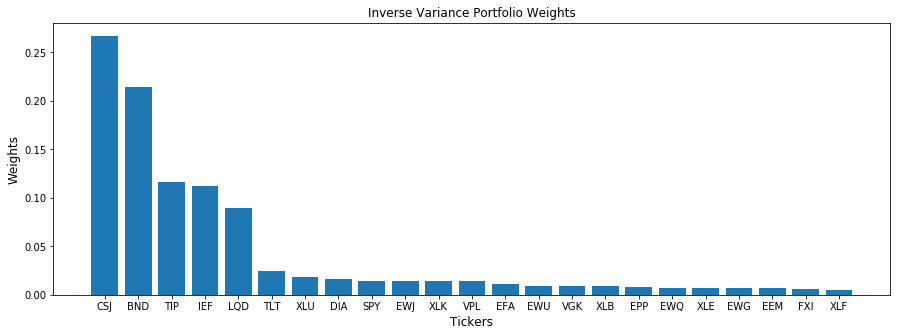

In [21]:
plt.figure(figsize=(15, 5))
plt.bar(ivp_weights.columns, ivp_weights.values[0])
plt.xlabel('Tickers', fontsize=12)
plt.ylabel('Weights', fontsize=12)
plt.title('Inverse Variance Portfolio Weights', fontsize=12)
plt.show()


We observe a clear difference in the allocation strategies of the 3 algorithms:

* CLA concentrates literally 99% of the holdings on the top-3 investments and assigns zero weight to all other assets. The reason behind CLA's extreme concentration is its goal of minimising the variance of the portfolio. This makes it very conservative in allocating weights and it places emphasis on only a few of the assets.

* Inverse variance (IVP) has assigned non-zero weights to all the assets and except the top 5 holdings, its weight allocations are distributed almost uniformly.

* HRP, on the other hand, tries to find a middle ground between CLA and IVP allocations. It places more emphasis on the top 5 holdings/assets just like IVP but assigns lesser values to the rest of the weights but not a uniform allocation.

* Another important fact is that both the CLA and HRP weights have very little difference in their standard deviations, $\sigma^{2}_{HRP} = 0.12$ and $\sigma^{2}_{CLA} = 0.15$. However, CLA has discarded half of the investment universe in favor of a minor risk reduction while HRP did not. Since, CLA has placed its emphasis on only a few of the assets, it is prone to much more negative impact by random shocks than HRP - something which we will see in the next set of questions.

## Question-16.3

### (a) Perform a spectral decomposition: VW=W$\wedge$

In the spectral decomposition above, **W refers to the eigenvectors matrix while $\wedge$ denotes the eigenvalues matrix - a diagonal matrix with eigenvalues along the diagonal**

In [22]:
N = stock_prices_downsampled.shape[1]


In [23]:
eigenvalues, eigenvectors = np.linalg.eig(V)
eigenvalues_matrix = np.identity(n=N) * eigenvalues


### (b) Form an array $\epsilon$ by drawing N random numbers from U[0, 1] distribution

In [24]:
epsilon = np.random.uniform(low=0, high=1, size=N)
epsilon


array([0.37454012, 0.95071431, 0.73199394, 0.59865848, 0.15601864,
       0.15599452, 0.05808361, 0.86617615, 0.60111501, 0.70807258,
       0.02058449, 0.96990985, 0.83244264, 0.21233911, 0.18182497,
       0.18340451, 0.30424224, 0.52475643, 0.43194502, 0.29122914,
       0.61185289, 0.13949386, 0.29214465])

### (c) Form an NxN matrix $\wedge^{'}$, where $\wedge^{'}_{n,n}=N\epsilon_{n}\wedge_{n,n}(\sum\epsilon_{n})^{-1}, n=1....N$

In [25]:
eigenvalues_matrix_modified = (N * epsilon * eigenvalues_matrix) / np.sum(epsilon)


### (d) Compute $V^{'}=W\wedge^{'}W^{-1}$

In [26]:
V_modified = eigenvectors @ eigenvalues_matrix_modified @ np.linalg.inv(eigenvectors)
V_modified = pd.DataFrame(V_modified)
V_modified.columns = V.columns
V_modified.index = V.index


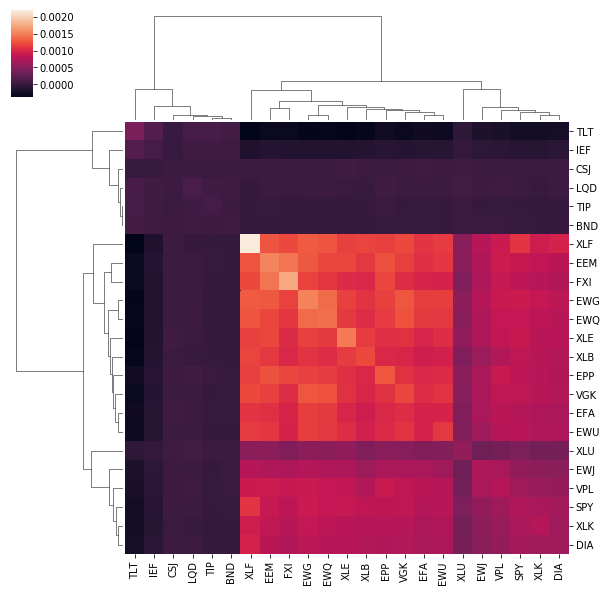

In [27]:
sns.clustermap(V)
plt.show()

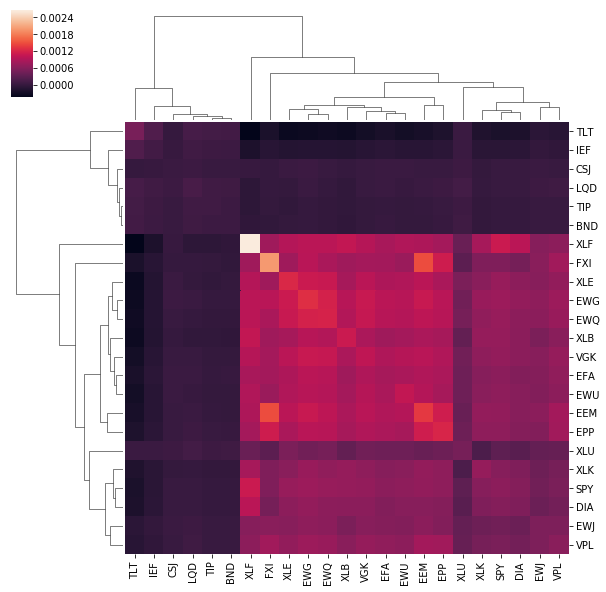

In [28]:
sns.clustermap(V_modified)
plt.show()

### (e) Repeat exercise 2, this time using $V^{'}$ as covariance matrix. What allocation method has been most impacted by the re-scaling of spectral variances?

In each of the 3 sections below, we use modified versions of the original algorithms implemented in the package. The only change is that wherever **covariance matrix is calculated from the data using asset_returns.cov(), we will use V_modified.** Everything else remains the same. These modified code files are present in the same folder with the following names - **hrp_modified.py, cla_modified.py, mvo_modified.py**. Except the changed function, the classes inherit all the other functions as it is from the respective parent classes.

### (i) HRP

In [29]:
hrp_modified = HierarchicalRiskParityModified()
hrp_modified.allocate(asset_prices=stock_prices,
                      resample_by='W',
                      covariance=V_modified)
hrp_modified_weights = hrp_modified.weights.sort_values(by=0, ascending=False, axis=1)


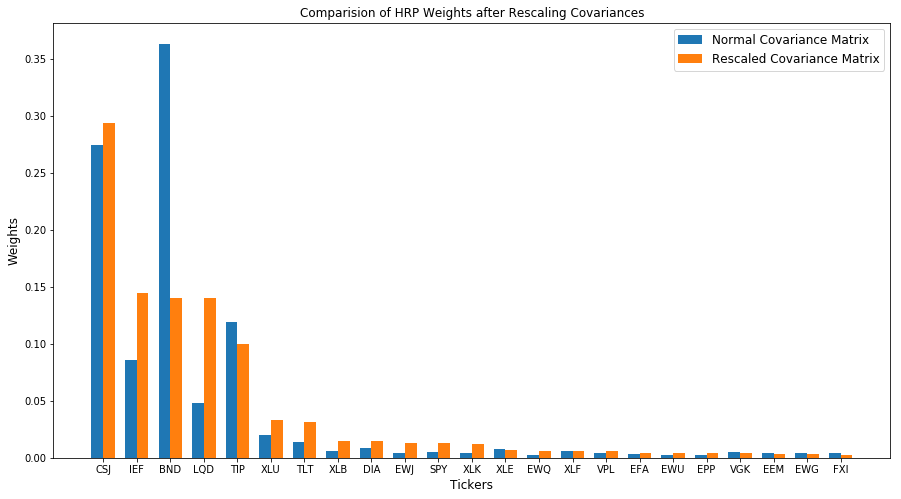

In [49]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
index = np.arange(N)
width = 0.35
ax.bar(index, hrp_weights[hrp_modified_weights.columns].values[0], width, label="Normal Covariance Matrix")
ax.bar(index + width, hrp_modified_weights.values[0], width, label="Rescaled Covariance Matrix")
ax.set_xticks(index + width / 2)
ax.set_xticklabels(hrp_modified_weights.columns)
plt.xlabel('Tickers', fontsize=12)
plt.ylabel('Weights', fontsize=12)
plt.title('Comparision of HRP Weights after Rescaling Covariances', fontsize=12)
plt.legend(fontsize='large')
plt.show()


### (ii) CLA

In [33]:
cla_modified = CLAModified()
cla_modified.allocate(asset_prices=stock_prices_downsampled,
                      solution='cla_turning_points',
                      covariance=V_modified)


In [34]:
cla_modified_weights = cla_modified.weights.mean(axis=0).reset_index()
cla_modified_weights.index = cla_modified_weights['index']
cla_modified_weights = cla_modified_weights.drop('index', 1)
cla_modified_weights = cla_modified_weights.T
cla_modified_weights = cla_modified_weights.sort_values(by=0, ascending=False, axis=1)


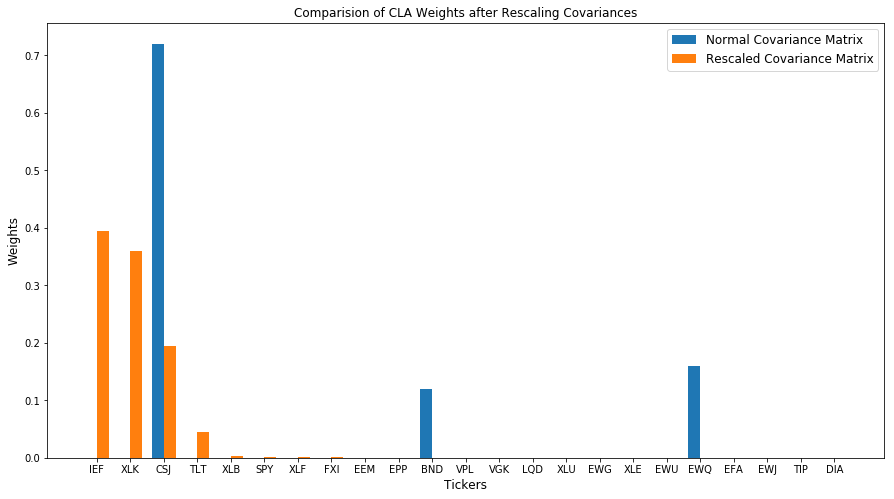

In [51]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
index = np.arange(N)
width = 0.35
ax.bar(index, cla_weights[cla_modified_weights.columns].values[0], width, label='Normal Covariance Matrix')
ax.bar(index + width, cla_modified_weights.values[0], width, label="Rescaled Covariance Matrix")
ax.set_xticks(index + width / 2)
ax.set_xticklabels(cla_modified_weights.columns)
plt.xlabel('Tickers', fontsize=12)
plt.ylabel('Weights', fontsize=12)
plt.title('Comparision of CLA Weights after Rescaling Covariances', fontsize=12)
plt.legend(fontsize='large')
plt.show()


### (iii) IVP

In [54]:
mvo_modified = MeanVarianceOptimisationModified()
mvo_modified.allocate(asset_prices=stock_prices,
                      covariance=V_modified,
                      solution='inverse_variance',
                      resample_by='W')
ivp_modified_weights = mvo_modified.weights.sort_values(by=0, ascending=False, axis=1)


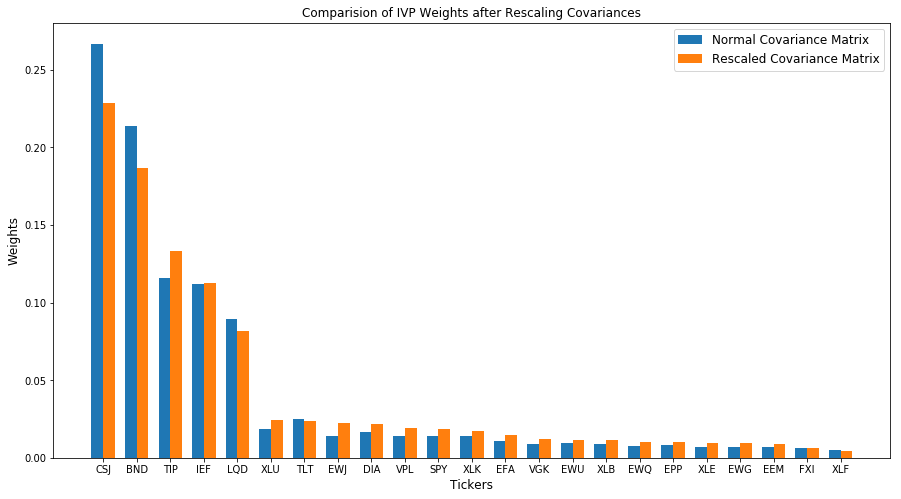

In [55]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
index = np.arange(N)
width = 0.35
ax.bar(index, ivp_weights[ivp_modified_weights.columns].values[0], width, label='Normal Covariance Matrix')
ax.bar(index + width, ivp_modified_weights.values[0], width, label="Rescaled Covariance Matrix")
ax.set_xticks(index + width / 2)
ax.set_xticklabels(ivp_modified_weights.columns)
plt.xlabel('Tickers', fontsize=12)
plt.ylabel('Weights', fontsize=12)
plt.title('Comparision of IVP Weights after Rescaling Covariances', fontsize=12)
plt.legend(fontsize='large')
plt.show()


We observe that rescaling of the variances has led to a rebalancing of the portfolios for all the three strategies. Lets see the differences in the rebalancing:

* HRP tries to rebalance the reduction in allocation of one affected investment across the other correlated investments in the cluster which were unaffected by the random shock. So, while allocation for BND goes down, the allocations for CSJ, IEF and LQD go up (These are in the same cluster as BND). At the same time, HRP also increases the allocations for other uncorrelated investments with lower variances.


* CLA behaves very erratically to the rescaling. It has actually increased the allocations for BND while HRP reduced it. Due to such an erratic behaviour, CLA tends to be impacted more negatively than HRP when there are such random idiosyncratic shocks.


* IVP tends to reduce the allocations for the affected investments and spread their change over the other investments which were unaffected. From the above graph, we see that it reduced allocations for CSJ and BND and then increased the allocations for the other investments irrespective of their correlations. This is because IVP only looks at the individual variances and does not take into account the covariances between 2 investments. This also makes it prone to negative impacts during such idiosyncratic shocks.

## Conclusion

We saw the Hierarchical Risk Parity algorithm in action on a real data of stock prices and also compared it to other classic algorithms like CLA and IVP. Some key takeaways from the exercise were:

* The HRP algorithm tries to allocate its weights in a stable manner - as a middle ground between CLA and IVP. 


* CLA tries to adopt a very conservative, risk-reduction approach and allocates its weights to the top few holdings while giving 0 importance to the other assets in the portfolio. This makes it very sensitive to random industry shocks. **Note that we are using CLA to find the minimum variance solution and these observations are based on that**


* IVP tries to allocate uniformly and it does not take into account the covariance and correlations between investments. It focuses on the invidivual asset variances.


* The last question actually confirms the previous points. Rescaling of covariance simulates an idiosyncratic shock in the industry where the covariances between the assets undergo a change which leads to a rebalancing of the portfolios across the 3 different strategies.
    * CLA behaves very erratically and becomes prone to much negative impacts during such scenarios.
    * HRP tries to rebalance in a stable manner taking into account the investments within the clusters of affected investments and also other uncorrelated investments outside the cluster.
    * IVP ignores the covariances and focuses on the individual variances. It spreads the allocations across unaffected investments uniformly irrespective of their correlations.
    
* Another major difference between CLA and HRP is that the former involves calculating inverse of the covariance matrix while the latter does not. Hence, even small changes in the covariances (e.g. rescaling them) will have a significatn impact on CLA allocations as compared to HRP.